In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from IPython.display import display

C:\Python399\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
import zipfile
with zipfile.ZipFile('../datasets/clothes.zip', 'r') as zip_ref:
    zip_ref.extractall('../datasets/clothes')

In [3]:
path = Path('../datasets/clothes')
fns = get_image_files(path)
fns

(#16170) [Path('../datasets/clothes/black_dress/1.jpg'),Path('../datasets/clothes/black_dress/10.jpg'),Path('../datasets/clothes/black_dress/100.jpg'),Path('../datasets/clothes/black_dress/101.jpg'),Path('../datasets/clothes/black_dress/102.jpg'),Path('../datasets/clothes/black_dress/103.jpg'),Path('../datasets/clothes/black_dress/104.jpg'),Path('../datasets/clothes/black_dress/105.jpg'),Path('../datasets/clothes/black_dress/106.jpg'),Path('../datasets/clothes/black_dress/107.jpg')...]

In [4]:
failed = verify_images(fns)
failed

(#0) []

In [16]:
import sys,os
path = '../datasets/clothes/'
df = pd.DataFrame(columns=['fname','label','fpath'])
fnames=[]
labels=[]
fpath=[]
for r,d,f in os.walk('../datasets/clothes/'):
    for file in f:
        fnames.append(parent_label(r+'/'+file)+os.path.join(file))#,parent_label(r+'/'+file))
        fpath.append(r+'/'+file)#,parent_label(r+'/'+file))
        labels.append(parent_label(r+'/'+file).replace('_',' '))
        
df['fname'] = pd.Series(fnames)
df['label'] = pd.Series(labels)
df['fpath'] = pd.Series(fpath)
df

,fname,label,fpath
0,black_dress1.jpg,black dress,../datasets/clothes/black_dress/1.jpg
1,black_dress10.jpg,black dress,../datasets/clothes/black_dress/10.jpg
2,black_dress100.jpg,black dress,../datasets/clothes/black_dress/100.jpg
3,black_dress101.jpg,black dress,../datasets/clothes/black_dress/101.jpg
4,black_dress102.jpg,black dress,../datasets/clothes/black_dress/102.jpg
...,...,...,...
16165,yellow_skirt000509.jpg,yellow skirt,../datasets/clothes/yellow_skirt/000509.jpg
16166,yellow_skirt000512.jpg,yellow skirt,../datasets/clothes/yellow_skirt/000512.jpg
16167,yellow_skirt000518.jpg,yellow skirt,../datasets/clothes/yellow_skirt/000518.jpg
16168,yellow_skirt000519.jpg,yellow skirt,../datasets/clothes/yellow_skirt/000519.jpg


In [159]:
path1 = '../datasets/photos'

In [160]:
def get_x(f): return path1/f['fname']
def get_y(f): return f['label']

In [161]:
flowers = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    get_x=get_x,
    item_tfms=RandomResizedCrop(128,min_scale=.35))

In [162]:
print(flowers)
flowers

In [163]:
dls = flowers.datasets(df,)

TypeError: expected str, bytes or os.PathLike object, not DataFrame

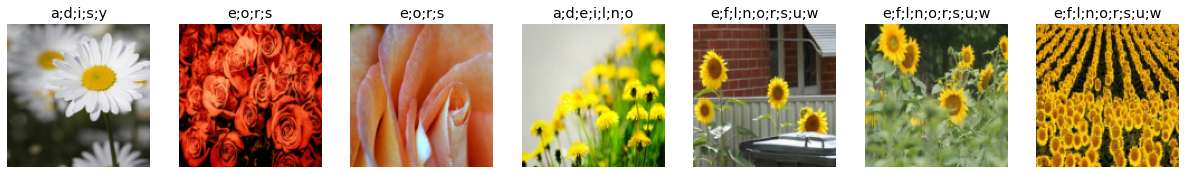

In [134]:
dls.valid.show_batch(max_n=7, nrows=1)

In [11]:
flowers = flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Python399\lib\site-packages\torch\_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [31]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.034909,0.365469,0.116686,03:11


epoch,train_loss,valid_loss,error_rate,time
0,0.471983,0.320727,0.098016,04:08
1,0.351130,0.268886,0.087515,04:03
2,0.266893,0.226213,0.073512,04:03
3,0.184052,0.209951,0.070012,04:05


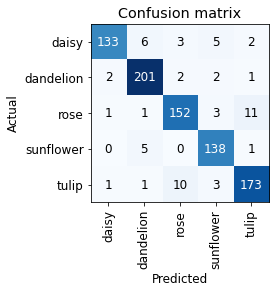

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [33]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

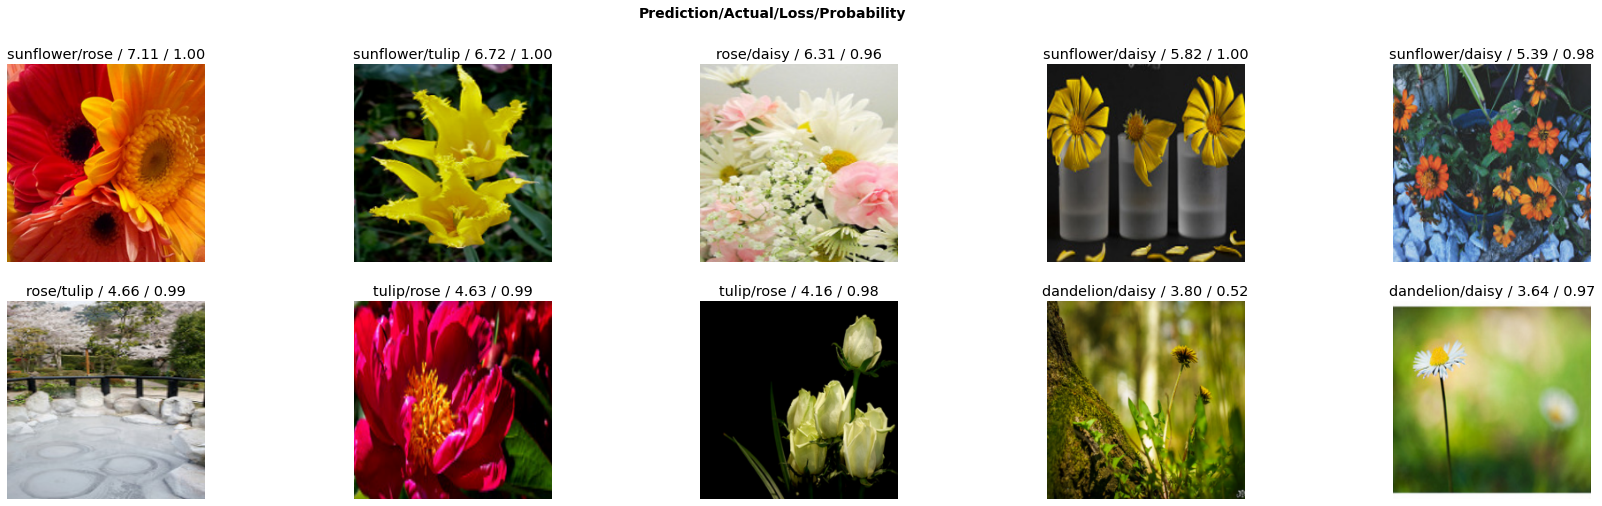

In [34]:
plot_top_losses_fix(interp, 10, nrows=2,figsize=[30,8])

In [43]:
try:
    cleaner = ImageClassifierCleaner(learn)
except:
    pass
cleaner

In [51]:
try:
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
except:
    pass
try:
    for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
except:
    pass

In [52]:
learn.export()

In [53]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [54]:
learn_inf = load_learner(path/'export.pkl')

In [56]:
learn_inf.predict('../datasets/flowers/daisy/43474673_7bb4465a86.jpg')

('daisy',
 TensorBase(0),
 TensorBase([1.0000e+00, 5.7774e-08, 1.8324e-08, 1.8281e-07, 5.1259e-08]))

In [66]:
# It does not work in Visual Studio Code
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [78]:
# Just a workaround as the button upload does work in VS Code
btn_upload = SimpleNamespace(data = ["C:/Users/bdacosta/Downloads/sunflower-types-1586794350.jpg"])

In [79]:
img = PILImage.create(btn_upload.data[-1])

In [81]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [82]:
pred,pred_idx,probs = learn_inf.predict(img)

In [83]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: sunflower; Probability: 1.0000')

In [84]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [85]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [86]:
btn_upload = widgets.FileUpload()

In [89]:
VBox([widgets.Label('Select your flower!'), 
      btn_upload, btn_run, out_pl, lbl_pred])